# IMPORT LIBRARIES

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sn

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras.utils.vis_utils import plot_model

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

In [ ]:
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix

%matplotlib inline

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()

# LOADING DATA

In [ ]:
data = yf.download(tickers ='EURUSD=X',start = '2013-12-13', end= '2022-11-11')

[*********************100%***********************]  1 of 1 completed


In [ ]:
data['returns'] = (data['Adj Close']/data['Adj Close'].shift(1)) -1
data['returnsclass'] = [1 if data.returns[i]>0 else 0 for i in range(len(data))]

In [ ]:
data.drop(['Volume'], axis=1, inplace=True)

In [ ]:
data.dropna(inplace=True)

In [ ]:
data_set = data.iloc[:, ]#.values
pd.set_option('display.max_columns', None)
data_set.drop(['returns'], axis=1, inplace=True)
data_set.head(5)

,Open,High,Low,Close,Adj Close,returnsclass
Date,,,,,,
2013-12-16,1.373815,1.379900,1.373815,1.373928,1.373928,0
2013-12-17,1.376178,1.378210,1.372701,1.376292,1.376292,1
2013-12-18,1.377107,1.378099,1.373479,1.377126,1.377126,1
2013-12-19,1.368307,1.369394,1.365113,1.368495,1.368495,0
2013-12-20,1.365598,1.370870,1.362583,1.365579,1.365579,0


# SINGLE LSTM

## DATA PROCESSING

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data_set)
print(data_set_scaled)
print(data_set_scaled[0].size)

[[0.95575293 0.95554347 0.96010293 0.95580024 0.95580024 0.        ]
 [0.96120628 0.95163066 0.95755404 0.96125319 0.96125319 1.        ]
 [0.96334911 0.95137574 0.95933491 0.96317718 0.96317718 1.        ]
 ...
 [0.09747834 0.09815244 0.09969114 0.09745652 0.09745652 1.        ]
 [0.11183391 0.09690325 0.10802951 0.11180888 0.11180888 1.        ]
 [0.09768685 0.11870528 0.09093904 0.09766498 0.09766498 0.        ]]
6


In [ ]:
X = []

backcandles = 14
print(data_set_scaled.shape[0])
for j in range(5):#data_set_scaled[0].size):#last column is target not X
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):#backcandles+2
        X[j].append(data_set_scaled[i-backcandles:i, j])

2321


In [ ]:
X=np.moveaxis(X, [0], [2])

In [ ]:
X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))
print(X)
print(X.shape)
print(y)
print(y.shape)

[[[0.95575293 0.95554347 0.96010293 0.95580024 0.95580024]
  [0.96120628 0.95163066 0.95755404 0.96125319 0.96125319]
  [0.96334911 0.95137574 0.95933491 0.96317718 0.96317718]
  ...
  [0.97181727 0.95867527 0.96537358 0.97212747 0.97212747]
  [0.9573214  0.9509233  0.96144159 0.9571071  0.9571071 ]
  [0.96216794 0.94991302 0.93598753 0.96212745 0.96212745]]

 [[0.96120628 0.95163066 0.95755404 0.96125319 0.96125319]
  [0.96334911 0.95137574 0.95933491 0.96317718 0.96317718]
  [0.94304367 0.93122927 0.94020116 0.94326461 0.94326461]
  ...
  [0.9573214  0.9509233  0.96144159 0.9571071  0.9571071 ]
  [0.96216794 0.94991302 0.93598753 0.96212745 0.96212745]
  [0.93916045 0.92637626 0.92889675 0.93903629 0.93903629]]

 [[0.96334911 0.95137574 0.95933491 0.96317718 0.96317718]
  [0.94304367 0.93122927 0.94020116 0.94326461 0.94326461]
  [0.93679179 0.93464413 0.9344155  0.9365389  0.9365389 ]
  ...
  [0.96216794 0.94991302 0.93598753 0.96212745 0.96212745]
  [0.93916045 0.92637626 0.9288967

In [ ]:
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

1845
(1845, 14, 5)
(462, 14, 5)
(1845, 1)
(462, 1)
[[0.]
 [0.]
 [1.]
 ...
 [1.]
 [1.]
 [0.]]


## MODEL

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 14, 5)]           0         
                                                                 
 first_layer (LSTM)          (None, 150)               93600     
                                                                 
 dense_layer (Dense)         (None, 1)                 151       
                                                                 
 output (Activation)         (None, 1)                 0         
                                                                 
Total params: 93,751
Trainable params: 93,751
Non-trainable params: 0
_________________________________________________________________


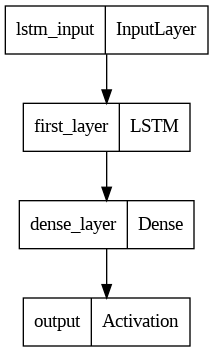

In [ ]:
np.random.seed(420)

lstm_input = Input(shape=(backcandles, 5), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('sigmoid', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
model.summary()
plot_model(model)

In [ ]:
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse', metrics=['accuracy'])
history= model.fit(x=X_train, y=y_train, batch_size=32, epochs=40, shuffle=True, validation_split = 0.15)

Epoch 1/40
49/49 [==============================] - 6s 29ms/step - loss: 0.2520 - accuracy: 0.4923 - val_loss: 0.2538 - val_accuracy: 0.4693
Epoch 2/40
49/49 [==============================] - 1s 20ms/step - loss: 0.2501 - accuracy: 0.5006 - val_loss: 0.2507 - val_accuracy: 0.4693
Epoch 3/40
49/49 [==============================] - 1s 22ms/step - loss: 0.2500 - accuracy: 0.5134 - val_loss: 0.2504 - val_accuracy: 0.4693
Epoch 4/40
49/49 [==============================] - 1s 25ms/step - loss: 0.2506 - accuracy: 0.4911 - val_loss: 0.2503 - val_accuracy: 0.4693
Epoch 5/40
49/49 [==============================] - 1s 23ms/step - loss: 0.2500 - accuracy: 0.5134 - val_loss: 0.2513 - val_accuracy: 0.4693
Epoch 6/40
49/49 [==============================] - 1s 21ms/step - loss: 0.2499 - accuracy: 0.5134 - val_loss: 0.2509 - val_accuracy: 0.4693
Epoch 7/40
49/49 [==============================] - 1s 20ms/step - loss: 0.2499 - accuracy: 0.5064 - val_loss: 0.2509 - val_accuracy: 0.4693
Epoch 8/40
49

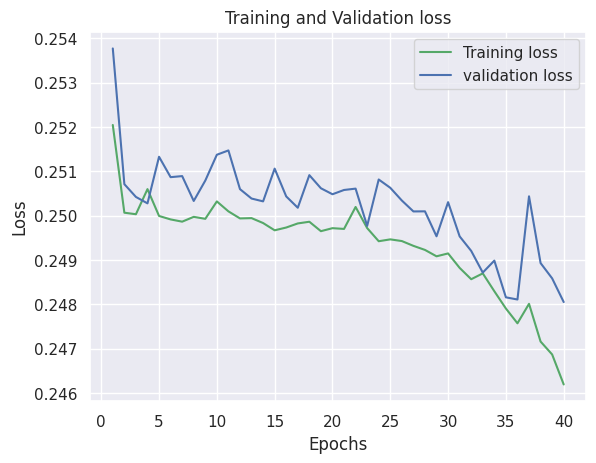

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,41)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

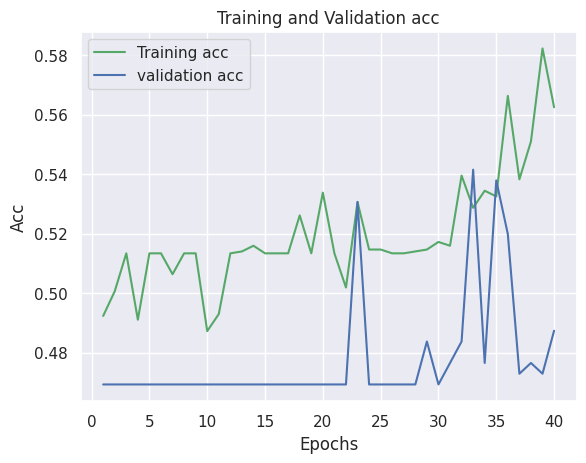

In [ ]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1,41)
plt.plot(epochs, acc_train, 'g', label='Training acc')
plt.plot(epochs, acc_val, 'b', label='validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred=np.where(y_pred > 0.50, 1,0)
for i in range(10):
    print(y_pred[i], y_test[i])

15/15 [==============================] - 1s 14ms/step
[0] [0.]
[0] [1.]
[0] [0.]
[0] [1.]
[0] [1.]
[0] [1.]
[0] [1.]
[0] [1.]
[0] [0.]
[0] [1.]


In [ ]:
print(classification_report(y_test, y_pred, digits=4))
print(confusion_matrix(y_test, y_pred))

MNB_f1 = round(f1_score(y_test, y_pred, average='weighted'), 3)
MNB_accuracy = round((accuracy_score(y_test, y_pred)*100),2)

print("Accuracy : " , MNB_accuracy , " %")
print("f1_score : " , MNB_f1)

              precision    recall  f1-score   support

         0.0     0.5721    0.9388    0.7110       245
         1.0     0.7500    0.2074    0.3249       217

    accuracy                         0.5952       462
   macro avg     0.6611    0.5731    0.5179       462
weighted avg     0.6557    0.5952    0.5296       462

[[230  15]
 [172  45]]
Accuracy :  59.52  %
f1_score :  0.53


Text(109.44999999999997, 0.5, 'Actual label')

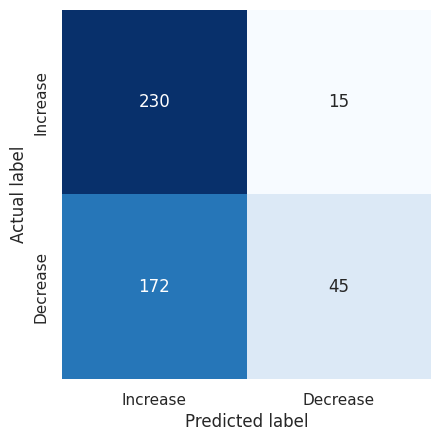

In [ ]:
mat = confusion_matrix(y_test, y_pred)
labels = ['Increase', 'Decrease']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

# STACKED LSTM

## DATA PROCESSING

In [ ]:
# Separate the features (historical prices and technical indicators) and the target (movement)
features = data_set.iloc[:, :-1]
target = data_set['returnsclass'].values

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.reshape(-1, 1))

In [ ]:
scaled_features.shape

(2321, 5)

In [ ]:
scaled_target.shape

(2321, 1)

In [ ]:
# Reshape the input data for LSTM (samples, time steps, features)
lookback = 14  # Number of previous time steps to consider
num_features = 5
num_samples = scaled_features.shape[0]

In [ ]:
num_sequences = num_samples - lookback + 1

In [ ]:
num_sequences

2308

In [ ]:
X = np.zeros((num_sequences, lookback, num_features))

for i in range(num_sequences):
    X[i] = scaled_features[i : i + lookback]
print(X.shape)

(2308, 14, 5)


In [ ]:
y = scaled_target[lookback-1:lookback-1+num_sequences]
y = np.reshape(y, (y.shape[0], 1))
print(y.shape)

(2308, 1)


In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(1846, 14, 5)
(1846, 1)


## MODEL

In [ ]:
# Create the LSTM model
model = Sequential()
model.add(LSTM(units=150, return_sequences=True, input_shape=(lookback, X_train.shape[2])))
model.add(Dropout(0.2))
# model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(units=75))
# model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 150)           93600     
                                                                 
 dropout (Dropout)           (None, 14, 150)           0         
                                                                 
 lstm_1 (LSTM)               (None, 75)                67800     
                                                                 
 dense (Dense)               (None, 1)                 76        
                                                                 
Total params: 161,476
Trainable params: 161,476
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile and train the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history= model.fit(X_train, y_train, epochs=40, batch_size=32, validation_split = 0.2)

Epoch 1/40
47/47 [==============================] - 16s 136ms/step - loss: 0.6974 - accuracy: 0.4980 - val_loss: 0.6925 - val_accuracy: 0.5189
Epoch 2/40
47/47 [==============================] - 6s 120ms/step - loss: 0.6941 - accuracy: 0.4980 - val_loss: 0.6928 - val_accuracy: 0.5216
Epoch 3/40
47/47 [==============================] - 5s 101ms/step - loss: 0.6932 - accuracy: 0.5034 - val_loss: 0.6918 - val_accuracy: 0.5216
Epoch 4/40
47/47 [==============================] - 4s 74ms/step - loss: 0.6932 - accuracy: 0.5115 - val_loss: 0.6917 - val_accuracy: 0.5216
Epoch 5/40
47/47 [==============================] - 3s 54ms/step - loss: 0.6934 - accuracy: 0.5020 - val_loss: 0.6917 - val_accuracy: 0.5216
Epoch 6/40
47/47 [==============================] - 3s 65ms/step - loss: 0.6935 - accuracy: 0.5136 - val_loss: 0.6920 - val_accuracy: 0.5216
Epoch 7/40
47/47 [==============================] - 2s 43ms/step - loss: 0.6931 - accuracy: 0.4980 - val_loss: 0.6920 - val_accuracy: 0.5216
Epoch 8/4

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

15/15 [==============================] - 0s 14ms/step - loss: 0.6323 - accuracy: 0.7251
Test Loss: 0.6322924494743347
Test Accuracy: 0.7251082062721252


In [ ]:
predictions = model.predict(X_test)

15/15 [==============================] - 1s 14ms/step


In [ ]:
threshold = 0.5  # Threshold to convert probabilities to binary labels

incorrect_predictions = []

# Convert predicted probabilities to binary labels
binary_predictions = np.where(predictions > threshold, 1, 0)

for true_label, predicted_label in zip(y_test, binary_predictions):
    if true_label != predicted_label:
        incorrect_predictions.append((true_label, predicted_label))

incorrect_predictions_count = len(incorrect_predictions)
print(f"Number of Incorrect Predictions: {incorrect_predictions_count}")

Number of Incorrect Predictions: 127


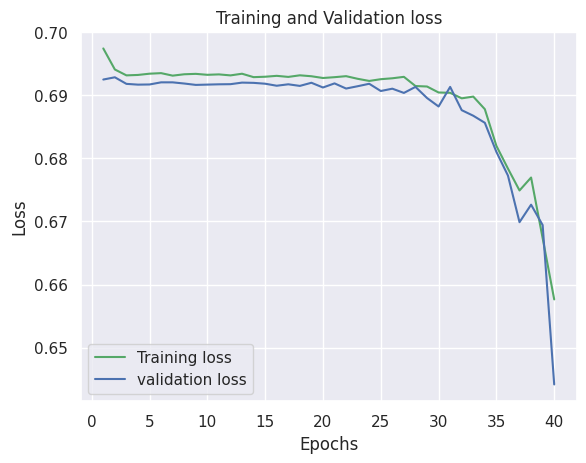

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,41)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

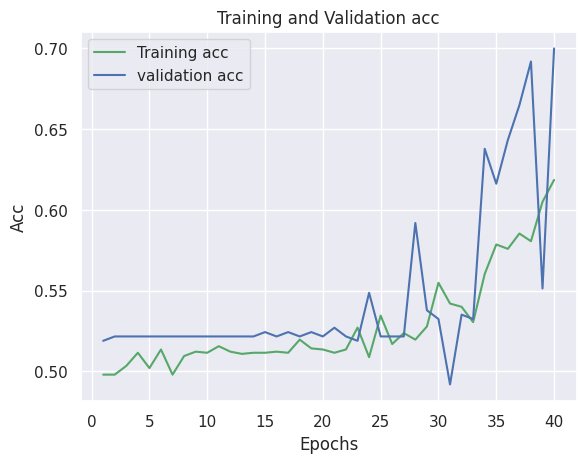

In [ ]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1,41)
plt.plot(epochs, acc_train, 'g', label='Training acc')
plt.plot(epochs, acc_val, 'b', label='validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Convert predicted probabilities to binary labels
binary_predictions = np.where(predictions > threshold, 1, 0)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, binary_predictions, digits=4))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, binary_predictions))

Classification Report:
              precision    recall  f1-score   support

         0.0     0.7397    0.6983    0.7184       232
         1.0     0.7119    0.7522    0.7315       230

    accuracy                         0.7251       462
   macro avg     0.7258    0.7252    0.7250       462
weighted avg     0.7259    0.7251    0.7249       462

Confusion Matrix:
[[162  70]
 [ 57 173]]


In [ ]:
# Prepare the input data for prediction (assuming X_test represents the most recent data available)
input_data = scaled_features[-lookback:]  # Select the most recent lookback period as input data

# Reshape the input data
input_data = np.reshape(input_data, (1, lookback, num_features))  # Adjust the shape based on your specific lookback and feature dimensions

# Make the prediction
prediction = model.predict(input_data)

# Interpret the prediction
if prediction > 0.5:
    price_movement = "Positive"
else:
    price_movement = "Negative"

# Print the predicted price movement
print("Next day's price movement:", price_movement)

1/1 [==============================] - 0s 28ms/step
Next day's price movement: Positive
